# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import os
import glob
import re
from colour import Color
from matplotlib.colors import LinearSegmentedColormap

# Configure matplotlib
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Suppress warnings
warnings.filterwarnings('ignore')


def make_colormap(colors, show_palette=False):
    """Create a custom colormap from a list of colors."""
    color_ramp = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors])
    if show_palette:
        plt.figure(figsize=(15, 3))
        plt.imshow([list(np.arange(0, len(colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
        plt.xticks([])
        plt.yticks([])
    return color_ramp


def reject_outliers(data, m=2):
    """Remove outliers from data based on standard deviation."""
    return data[abs(data - np.mean(data)) < m * np.std(data)]


def rgb2hex(vals, rgbtype=1):
    """Convert RGB values to hex color codes.
    
    Args:
        vals: RGB/RGBA tuple
        rgbtype: 1 for 0-1 range, 256 for 0-255 range
    
    Returns:
        Hex string in format '#RRGGBB' or '#RRGGBBAA'
    """
    if len(vals) not in [3, 4]:
        raise Exception("RGB or RGBA inputs must have three or four elements!")
    if rgbtype not in [1, 256]:
        raise Exception("rgbtype must be 1 or 256!")

    # Convert from 0-1 RGB/RGBA to 0-255 RGB/RGBA
    if rgbtype == 1:
        vals = [255 * x for x in vals]

    # Ensure values are rounded integers, convert to hex, and concatenate
    return '#' + ''.join(['{:02X}'.format(int(round(x))) for x in vals])

def create_color_map(colors):
    """Create a LinearSegmentedColormap from color list."""
    return LinearSegmentedColormap.from_list('custom_map', colors)


def get_color_ranks(values):
    """Get normalized color ranks for values."""
    ranks = values.rank(ascending=False)
    normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    return 1 - np.power(normalized_ranks, 0.7)

# Color palettes for different metrics
metric_overall_colormap = ['#2D203E', '#704774', '#B77D9F', '#E0B3BD', '#F4E2E1']
metric_sample_colormap = ['#0A1D58', '#235FA8', '#40B6C4', '#C7E9B4', '#FDFFAB']
metric_bio_colormap = ['#49006A', '#AE007E', '#F768A1', '#FCC5C0', '#FFE9DE']
metric_batch_colormap = ['#4D004A', '#88419D', '#8C96C6', '#BFD3E6', '#CEF5FD']
metric_modality_colormap = ['#390099', '#9381ff', '#b8b8ff', '#d0d0fc', '#f8f7ff']
metric_continuity_colormap = ['#8c2104', '#f93f06', '#ff6b35', '#f7c59f', '#ffe8dc']
metric_marker_colormap = ['#002D4F', '#6BB0ED', '#92CCF7', '#B1D8FC', '#E1EDF9']
metric_reconstruction_colormap = ['#081c15', '#2d6a4f', '#52b788', '#95d5b2', '#d8f3dc']
metric_time_colormap = ['#000000', '#4d4d4d', '#999999', '#cccccc', '#ffffff']

# Color dictionary mapping
color_dict = {
    'total_score': metric_overall_colormap,
    'continuity': metric_continuity_colormap,
    'marker_score': metric_marker_colormap,
    'reconstruction': metric_reconstruction_colormap,
    'biological_conservation': metric_bio_colormap,
    'batch_correction': metric_batch_colormap,
    'cross_sample': metric_sample_colormap,
    'cross_modality': metric_modality_colormap,
    'time_memory': metric_time_colormap
}

# Method color mapping
method_color_dict = {
    "spatialMETA": "#8873a4",
    "spatialGLUE": "#beb1d6",
    "spaVAE": "#a2cbec",
    "spaMultiVAE": "#16a9ca",
    "scVI": "#f4afc1",
    "scANVI": "#e17492",
    "totalVI": "#9e365c",
    "scPoli": "#f7c770",
    "Stabmap": "#8b97ab",
    "Seurat RPCA": "#189067",
    "Seurat CCA": "#5cbc93",
    "SeuratV5_BNN": "#c0dfb6",
    "PCA": "#c8d0c4",
    "MISO": "#C88EA7",
    "MISO_2m":"#F28BBC",
    "MISO_3m":"#B74B7F"
    
}

# Method name conversion dictionary
convert_dict = {
    'MISO_2m': 'MISO_2m',
    'MISO_3m': 'MISO_3m',
    'PCA_baseline': 'PCA', 
    'Seurat_BNN_run': 'SeuratV5_BNN', 
    'spaMultiVAE': 'spaMultiVAE',
    'SpatialMETA_run': 'spatialMETA', 
    'TotalVI_run': 'totalVI', 
    'SpatialGlue_run': 'spatialGLUE', 
    'Stabmap_run': 'Stabmap'
}

/home/snow/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Read table and preprocess

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations

In [3]:
df = pd.read_csv("/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/modality_results_raw_final_with_miso3m.csv",index_col=0)

In [4]:
df.columns

Index(['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'file_name', 'embedding_method', 'Peak RSS (MB)',
       'Time Taken (seconds)', 'MAE', 'Mean_PCC', 'Mean_Cosine_Si

In [5]:
df.columns = ['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'file_name', 'method', 'memory',
       'time', 'MAE', 'mean_pcc', 'mean_cos_sim']

In [6]:
df.method = df.method.replace(convert_dict)

## Scale 0-1

In [7]:
# the metrics need to 1-
for col in ['CHAOS', 'PAS']:
    if col in df.columns:
        df[col] = 1 - df[col]

In [8]:
from sklearn.preprocessing import MinMaxScaler
special_scale_cols = ['mean_pcc', 'mean_cos_sim']
for col in special_scale_cols:
    if col in df.columns:
        # Temporarily fill None with 0
        temp = df[col].copy()
        temp_filled = temp.fillna(0)
        # Scale to [0, 1]
        scaled = MinMaxScaler().fit_transform(temp_filled.values.reshape(-1, 1)).flatten()
        # Restore 0s to None (if they were originally None)
        scaled[temp.isna()] = np.nan
        df[col] = scaled

In [9]:
scale_cols = [
    'SM_specificity_thresh100', 'ST_specificity_thresh100', 'SM_specificity_thresh99',
    'ST_specificity_thresh99', 'SM_specificity_thresh98', 'ST_specificity_thresh98',
    'SM_specificity_thresh95', 'ST_specificity_thresh95', 'ST_logistic', 
    'SM_logistic', 'ST_mi', 'SM_mi'
]

for col in scale_cols:
    if col in df.columns:
        df[col] = MinMaxScaler().fit_transform(df[[col]])

## calculate the grouped df

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]
df_grouped = df_numeric.groupby(df['method']).mean()

In [11]:
df_grouped.loc[:,['time','memory']]

,time,memory
method,,
MISO_2m,19.249364,3498.418182
MISO_3m,57.817273,4791.963636
PCA,5.632727,861.310909
SeuratV5_BNN,17.709091,855.526364
Stabmap,15.657273,1448.205455
spaMultiVAE,1153.320000,1686.655636
spatialGLUE,14.852727,1337.496364
spatialMETA,38.576364,1885.326364
totalVI,124.700000,1655.560909


## Calculate the mean score for thresh or top

In [12]:
def calculate_mean_metrics(df):
    """Calculate mean metrics for columns with 'top' or 'thresh' patterns."""
    prefix_groups = {}
    for col in df.columns:
        match = re.match(r'(.+?)_(top|thresh)', col)
        if match:
            prefix = match.group(1)
            if prefix not in prefix_groups:
                prefix_groups[prefix] = []
            prefix_groups[prefix].append(col)
    
    for prefix, cols in prefix_groups.items():
        df[f'{prefix}_mean'] = df[cols].mean(axis=1)
    
    return df

In [13]:
df_mean = calculate_mean_metrics(df_grouped)

In [14]:
df_mean.columns

Index(['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'memory', 'time', 'mean_pcc', 'mean_cos_sim', 'ST_moranI_mean',
       'ST_gearyC_mean', 'SM_moranI_mean', 'SM_gear

## calculate the overall score

In [26]:
continuity_metrics = ['CHAOS', 'PAS']

# Simplified marker score metrics using mean values
marker_score_metrics = [
    'ST_moranI_mean', 'SM_moranI_mean', 'ST_gearyC_mean', 'SM_gearyC_mean',
    'ST_specificity_mean', 'SM_specificity_mean',
    'ST_logistic', 'SM_logistic', 'ST_mi', 'SM_mi'
]

biological_conservation_metrics = ['ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette']
#batch_correction_metrics = ["batch_asw", "ilisi_graph", "pcr"]
reconstruction_metrics = ["mean_pcc", "mean_cos_sim"]
scalability_metrics = ["time", "memory"]
cross_modality_metrics = ["continuity_mean","marker_score_mean","reconstruction_mean"]
#total_memtrics = ['continuity_mean','marker_score_mean','biological_conservation_mean','reconstruction_mean']
total_memtrics = ["continuity_mean","marker_score_mean","reconstruction_mean",'biological_conservation_mean']

In [27]:
df_mean['continuity_mean'] = df_mean[continuity_metrics].mean(axis=1)
df_mean['marker_score_mean'] = df_mean[marker_score_metrics].mean(axis=1)
df_mean['biological_conservation_mean'] = df_mean[biological_conservation_metrics].mean(axis=1)

In [28]:
df_mean['reconstruction_mean'] = df_mean[reconstruction_metrics].mean(axis=1)

In [29]:
df_mean['cross_modality_mean'] = df_mean[cross_modality_metrics].mean(axis=1)

In [30]:
df_mean['total_score'] = df_mean[total_memtrics].mean(axis=1)

In [31]:
df_mean.loc[:,['continuity_mean','marker_score_mean','biological_conservation_mean','reconstruction_mean',
               'cross_modality_mean',
               'total_score']]

,continuity_mean,marker_score_mean,biological_conservation_mean,reconstruction_mean,cross_modality_mean,total_score
method,,,,,,
MISO_3m,0.929343,0.528408,0.593436,NaN,0.728876,0.683729
spatialMETA,0.837570,0.519945,0.552906,0.901096,0.752870,0.702879
SeuratV5_BNN,0.834513,0.541732,0.558303,NaN,0.688123,0.644850
MISO_2m,0.855100,0.535152,0.547068,NaN,0.695126,0.645773
totalVI,0.728387,0.467834,0.506735,0.663191,0.619804,0.591537
PCA,0.740498,0.441122,0.466506,NaN,0.590810,0.549375
spatialGLUE,0.763735,0.413732,0.445390,NaN,0.588733,0.540952
spaMultiVAE,0.669511,0.449990,0.468327,0.484007,0.534503,0.517959
Stabmap,0.545772,0.300167,0.353282,NaN,0.422970,0.399740


In [32]:
df_mean.loc[:,['time','memory']]

,time,memory
method,,
MISO_3m,57.817273,4791.963636
spatialMETA,38.576364,1885.326364
SeuratV5_BNN,17.709091,855.526364
MISO_2m,19.249364,3498.418182
totalVI,124.700000,1655.560909
PCA,5.632727,861.310909
spatialGLUE,14.852727,1337.496364
spaMultiVAE,1153.320000,1686.655636
Stabmap,15.657273,1448.205455


# Visualization

In [33]:
df_mean.columns

Index(['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'memory', 'time', 'mean_pcc', 'mean_cos_sim', 'ST_moranI_mean',
       'ST_gearyC_mean', 'SM_moranI_mean', 'SM_gear

## overall score

In [34]:
output_dir = "/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization"
sample_chosen = "cross_modality"


In [35]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

df_mean = df_mean.sort_values('total_score', ascending=False)

# time 和 memory列转化为rank
#df_mean['time'] = df_mean['time'].rank(ascending=False)
#df_mean['memory'] = df_mean['memory'].rank(ascending=False)

methods = df_mean.index


gs_kw = dict(width_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3])


def create_color_map(colors):
    return LinearSegmentedColormap.from_list('custom_map', colors)

def get_color_ranks(values):
    ranks = values.rank(ascending=False)
    normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    return 1 - np.power(normalized_ranks, 0.7)


### barplot （time and memory value）

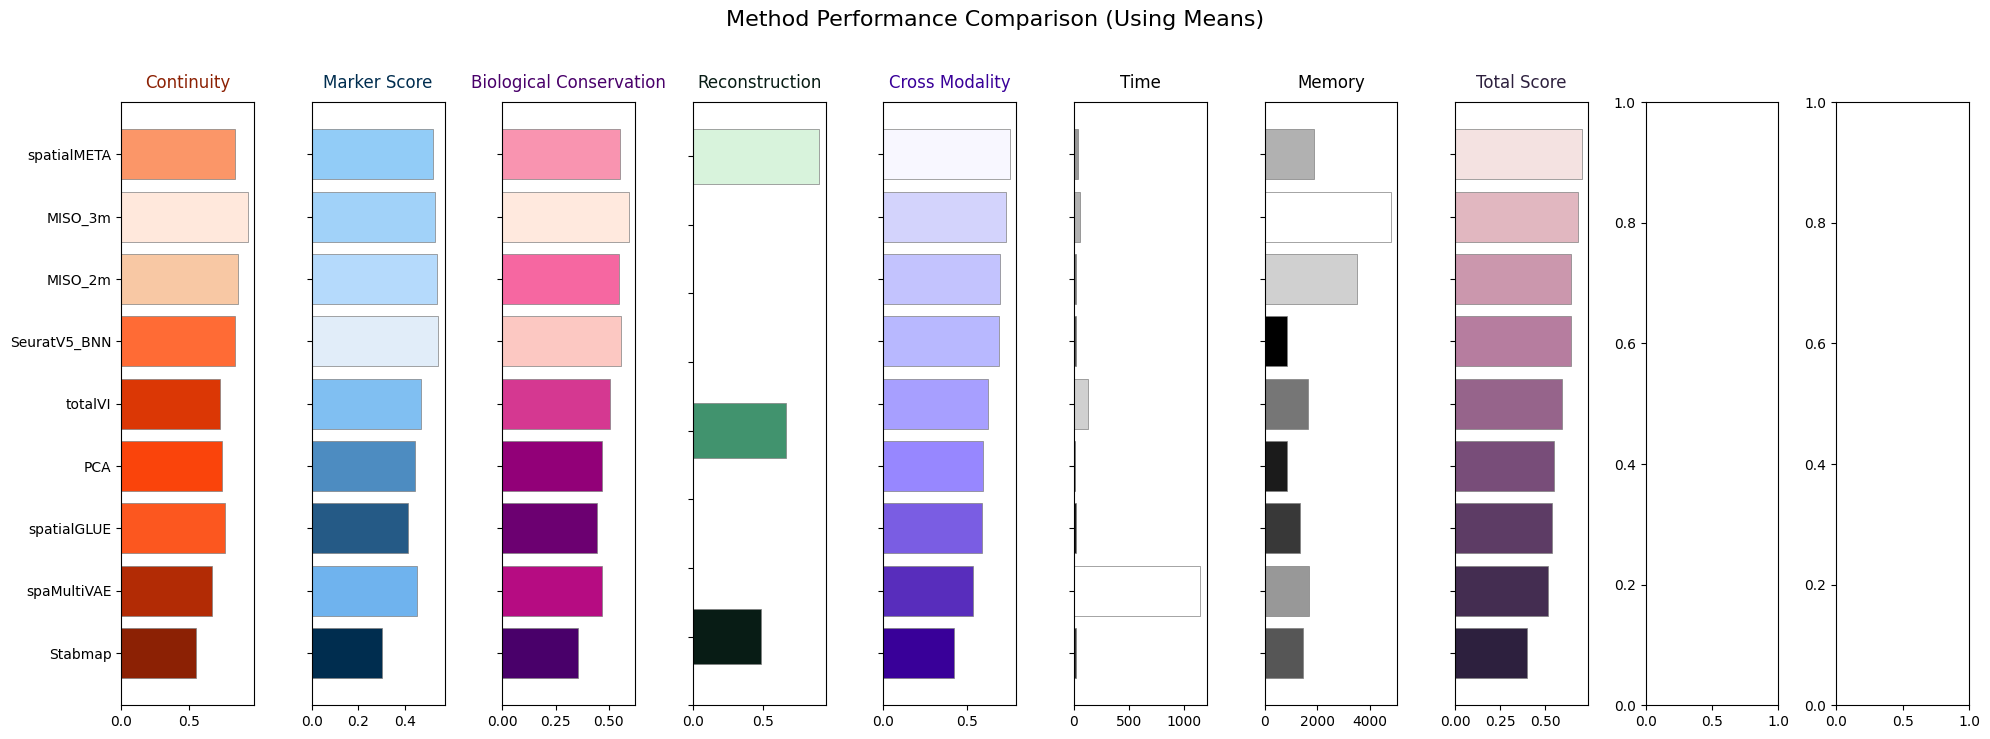

In [36]:
#df_mean['time'] = df_mean['time'].rank(ascending=False)
#df_mean['memory'] = df_mean['memory'].rank(ascending=False)
fig1, axes1 = plt.subplots(1, 10, figsize=(20, len(methods) * 0.8))

mean_metrics = [
    ('continuity_mean', 'Continuity', create_color_map(color_dict['continuity'])),
    ('marker_score_mean', 'Marker Score', create_color_map(color_dict['marker_score'])),
    ('biological_conservation_mean', 'Biological Conservation', create_color_map(color_dict['biological_conservation'])),
    #('batch_correction_mean', 'Batch Correction', create_color_map(color_dict['batch_correction'])),
    ('reconstruction_mean', 'Reconstruction', create_color_map(color_dict['reconstruction'])),
    ('cross_modality_mean', 'Cross Modality', create_color_map(color_dict['cross_modality'])),
    #('cross_sample_mean', 'Cross Sample', create_color_map(color_dict['cross_sample'])),
    ('time', 'Time', create_color_map(color_dict['time_memory'])),
    ('memory', 'Memory', create_color_map(color_dict['time_memory'])),
    ('total_score', 'Total Score', create_color_map(color_dict['total_score']))
]

for i, (col, title, cmap) in enumerate(mean_metrics):
    values = df_mean[col]
    color_ranks = get_color_ranks(values)
    colors = [cmap(x) for x in color_ranks]

    if col == 'reconstruction_mean' and values.isnull().all():
        colors = [color_dict['reconstruction'][-1]] * len(methods)

    axes1[i].barh(
        y=range(len(methods)),
        width=values,
        color=colors,
        edgecolor='gray',
        linewidth=0.5
    )

    if col == 'time' or col == 'memory':
        axes1[i].set_title(title, fontsize=12, pad=10, color=color_dict['time_memory'][0])
    else:
        axes1[i].set_title(title, fontsize=12, pad=10, color=color_dict[col.replace('_mean', '')][0])
    axes1[i].set_yticks(range(len(methods)))
    if i == 0:
        axes1[i].set_yticklabels(methods, fontsize=10)
    else:
        axes1[i].set_yticklabels([])
    axes1[i].invert_yaxis()

plt.suptitle("Method Performance Comparison (Using Means)", fontsize=16, y=1.02)
plt.tight_layout()
fig1_path = os.path.join(output_dir, f"{sample_chosen}_means_ruonan.pdf")
plt.savefig(fig1_path, bbox_inches='tight')


### dotplot

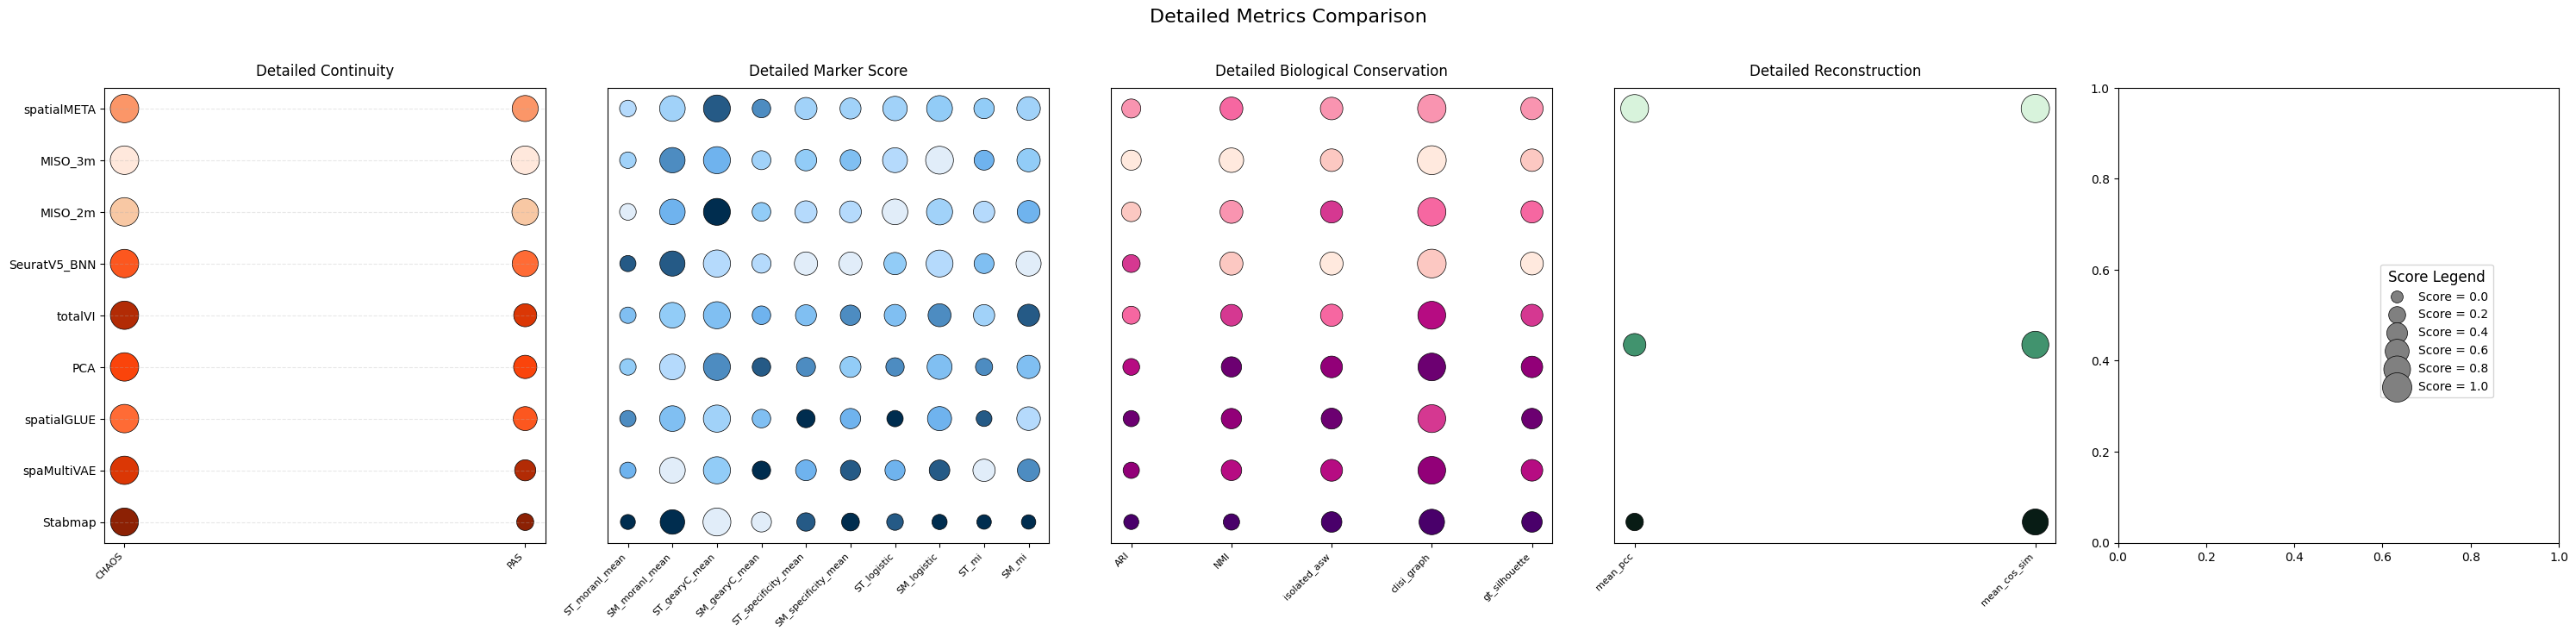

In [38]:
fig2, axes2 = plt.subplots(1, 5, figsize=(30, len(methods) * 0.8))

metric_groups = [
    ('Continuity', continuity_metrics, color_dict['continuity']),
    ('Marker Score', marker_score_metrics, color_dict['marker_score']),
    ('Biological Conservation', biological_conservation_metrics, color_dict['biological_conservation']),
    #('Batch Correction', batch_correction_metrics, color_dict['batch_correction']),
    ('Reconstruction', reconstruction_metrics, color_dict['reconstruction'])
]

# 定义图例的值和对应的大小
score_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # 图例显示的分数值
size_scale = np.array([100, 200, 300, 400, 500, 600])  # 对应的点大小

# 创建一个额外的轴用于放置图例
legend_ax = fig2.add_axes([0.92, 0.3, 0.02, 0.4])  # [left, bottom, width, height]
legend_ax.axis('off')

# 创建图例的代理对象
legend_elements = [plt.scatter([], [], s=size, c='gray', 
                             edgecolor='black', lw=0.5,
                             label=f'Score = {value:.1f}')
                  for size, value in zip(size_scale, score_values)]

# 添加图例
legend = legend_ax.legend(handles=legend_elements, 
                         title='Score Legend',
                         loc='center left',
                         frameon=True,
                         fontsize=10)
legend.get_title().set_fontsize(12)

for i, (group_name, metrics, colors) in enumerate(metric_groups):
    ax = axes2[i]
    
    for j, metric in enumerate(metrics):
        values = df_mean[metric]
        color_ranks = get_color_ranks(values)
        cmap = create_color_map(colors)
        point_colors = [cmap(x) for x in color_ranks]

        if group_name == 'Reconstruction' and values.sum() == 0:
            point_colors = [colors[-1]] * len(methods)

        # 将值映射到定义的大小范围
        sizes = np.interp(values, [0, 1], [size_scale[0], size_scale[-1]])

        ax.scatter(
            x=[j] * len(methods),
            y=range(len(methods)),
            s=sizes,  # 使用映射后的大小
            c=point_colors,
            edgecolor='black', 
            lw=0.5
        )

    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics, rotation=45, ha='right', fontsize=8)
    ax.set_title(f'Detailed {group_name}', fontsize=12, pad=10)
    ax.invert_yaxis()
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    
    if i == 0:
        ax.set_yticks(range(len(methods)))
        ax.set_yticklabels(methods, fontsize=10)
    else:
        ax.set_yticks([])

plt.suptitle("Detailed Metrics Comparison", fontsize=16, y=1.02)
plt.tight_layout()
fig2_path = os.path.join(output_dir, f"{sample_chosen}_detailed_ruonan.pdf")
plt.savefig(fig2_path, bbox_inches='tight')


### barplot （time and memory rank）

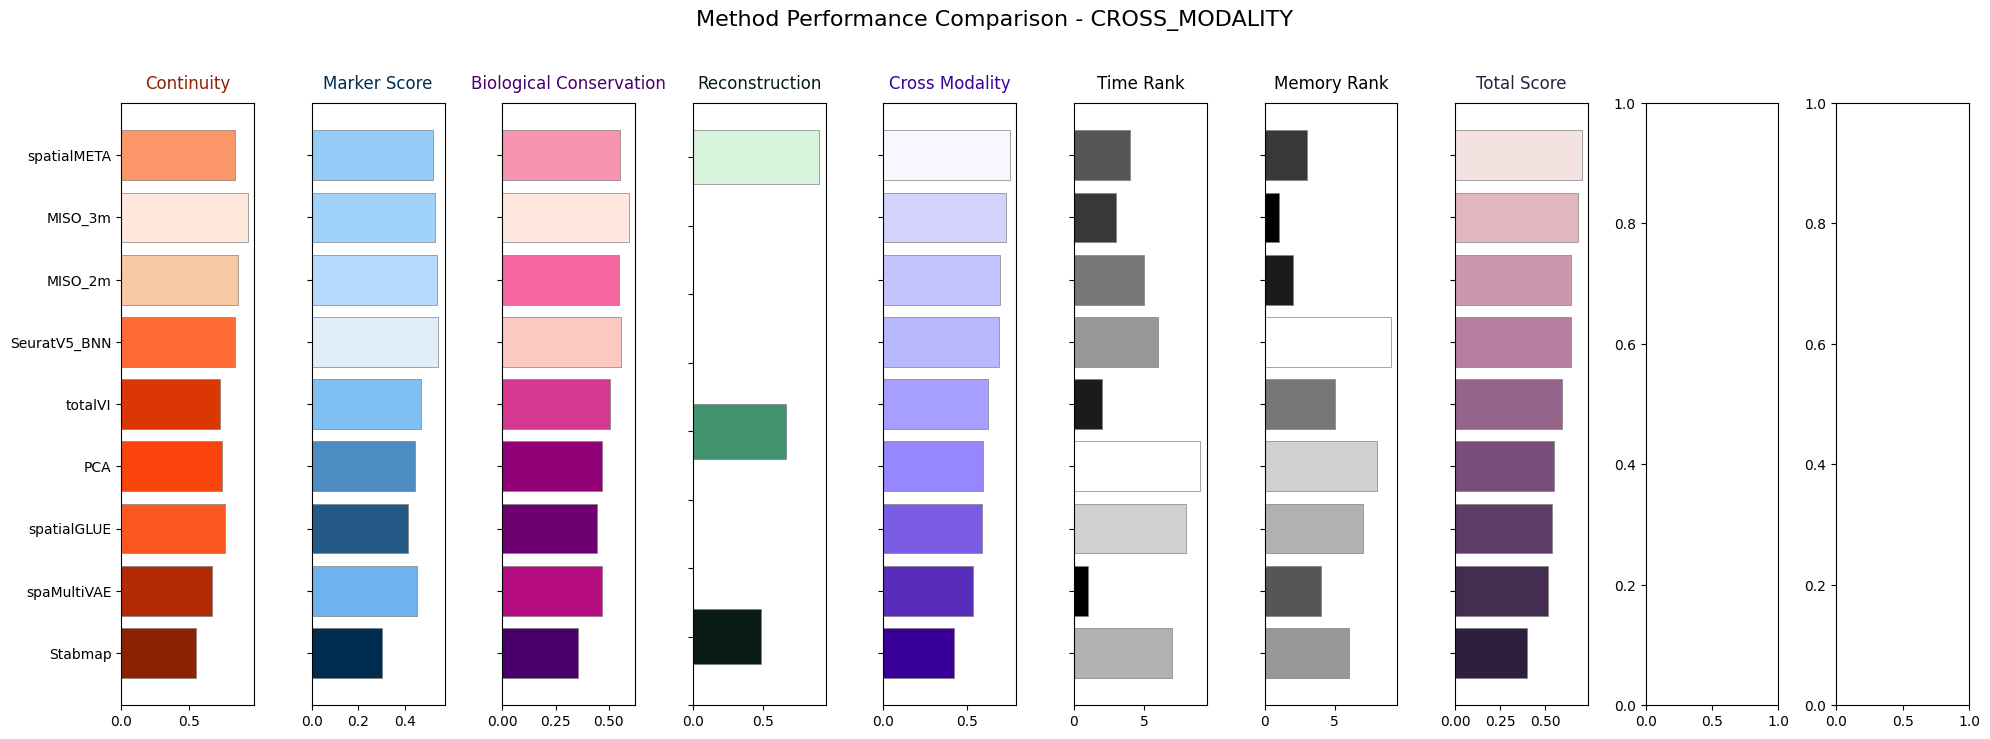

Performance comparison chart saved as cross_modality_performance_comparison.pdf


In [39]:
# Prepare data for visualization
methods = df_mean.index

# Convert time and memory to ranks for better visualization
if 'time' in df_mean.columns:
    df_mean['time_display'] = df_mean['time'].rank(ascending=False)
if 'memory' in df_mean.columns:
    df_mean['memory_display'] = df_mean['memory'].rank(ascending=False)

# Create the main performance comparison chart
fig1, axes1 = plt.subplots(1, 10, figsize=(20, len(methods) * 0.8))

mean_metrics = [
    ('continuity_mean', 'Continuity', create_color_map(color_dict['continuity'])),
    ('marker_score_mean', 'Marker Score', create_color_map(color_dict['marker_score'])),
    ('biological_conservation_mean', 'Biological Conservation', create_color_map(color_dict['biological_conservation'])),
    #('batch_correction_mean', 'Batch Correction', create_color_map(color_dict['batch_correction'])),
    ('reconstruction_mean', 'Reconstruction', create_color_map(color_dict['reconstruction'])),
    ('cross_modality_mean', 'Cross Modality', create_color_map(color_dict['cross_modality'])),
    #('cross_sample_mean', 'Cross Sample', create_color_map(color_dict['cross_sample'])),
    ('time_display', 'Time Rank', create_color_map(color_dict['time_memory'])),
    ('memory_display', 'Memory Rank', create_color_map(color_dict['time_memory'])),
    ('total_score', 'Total Score', create_color_map(color_dict['total_score']))
]

for i, (col, title, cmap) in enumerate(mean_metrics):
    if col not in df_mean.columns:
        continue
        
    values = df_mean[col]
    color_ranks = get_color_ranks(values)
    colors = [cmap(x) for x in color_ranks]

    # Handle special cases
    if col == 'reconstruction_mean' and values.sum() == 0:
        colors = [color_dict['reconstruction'][-1]] * len(methods)

    axes1[i].barh(
        y=range(len(methods)),
        width=values,
        color=colors,
        edgecolor='gray',
        linewidth=0.5
    )

    # Set title colors
    if 'time' in col or 'memory' in col:
        title_color = color_dict['time_memory'][0]
    else:
        metric_key = col.replace('_mean', '').replace('_display', '')
        title_color = color_dict.get(metric_key, '#000000')[0]
    
    axes1[i].set_title(title, fontsize=12, pad=10, color=title_color)
    axes1[i].set_yticks(range(len(methods)))
    
    if i == 0:
        axes1[i].set_yticklabels(methods, fontsize=10)
    else:
        axes1[i].set_yticklabels([])
    
    axes1[i].invert_yaxis()

plt.suptitle(f"Method Performance Comparison - {sample_chosen.upper()}", fontsize=16, y=1.02)
plt.tight_layout()
fig_performance_path = os.path.join(output_dir, f"{sample_chosen}_performance_comparison.pdf")
plt.savefig(fig_performance_path, bbox_inches='tight')
plt.show()

print(f"Performance comparison chart saved as {sample_chosen}_performance_comparison.pdf")

## boxplot

In [61]:
df_raw = pd.read_csv("/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/modality_results_raw_final_with_miso3m.csv",index_col=0)

In [62]:
df_raw.columns = ['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20',
       'ST_gearyC_top20', 'ST_moranI_top50', 'ST_gearyC_top50',
       'ST_moranI_top100', 'ST_gearyC_top100', 'ST_moranI_top200',
       'ST_gearyC_top200', 'ST_moranI_top500', 'ST_gearyC_top500',
       'SM_moranI_top5', 'SM_gearyC_top5', 'SM_moranI_top20', 'SM_gearyC_top20',
       'SM_moranI_top50', 'SM_gearyC_top50', 'SM_moranI_top100',
       'SM_gearyC_top100', 'SM_moranI_top200', 'SM_gearyC_top200',
       'SM_specificity_thresh100', 'ST_specificity_thresh100',
       'SM_specificity_thresh99', 'ST_specificity_thresh99',
       'SM_specificity_thresh98', 'ST_specificity_thresh98',
       'SM_specificity_thresh95', 'ST_specificity_thresh95', 'ST_logistic',
       'SM_logistic', 'ST_mi', 'SM_mi', 'file_name', 'method', 'memory',
       'time', 'MAE', 'mean_pcc', 'mean_cos_sim']

In [63]:
df_raw.method = df_raw.method.replace(convert_dict)

In [64]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [65]:
df_raw.columns

Index(['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'file_name', 'method', 'memory', 'time', 'MAE', 'mean_pcc',
       'mean_cos_sim'],
      dtype='object')

In [66]:
output_dir = "/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization"
sample_chosen = "cross_modality"

In [67]:
exclude_cols = ['method', 'file_name', 'leiden_clusters','ASW','MAE']
metrics = [col for col in df_raw.columns if col not in exclude_cols]
n_metrics = len(metrics)
n_cols = 3  
n_rows = (n_metrics + n_cols - 1) // n_cols

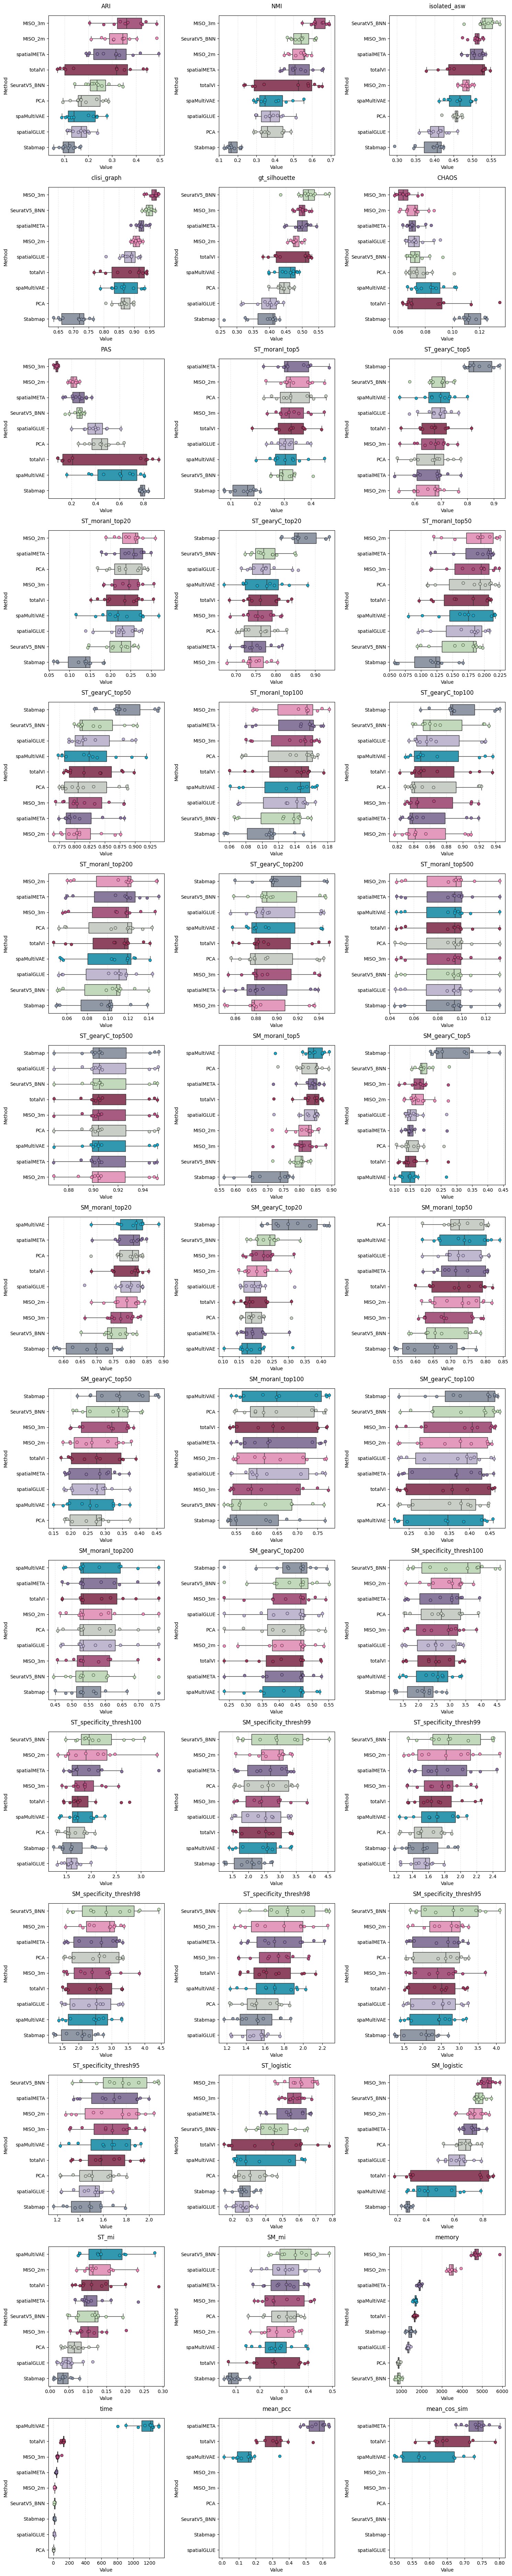

In [69]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()


for idx, metric in enumerate(metrics):
    ax = axes[idx]

    ascending = True if metric in ['CHAOS', 'PAS'] else False
    method_means = df_raw.groupby('method')[metric].mean()
    method_order = method_means.sort_values(ascending=ascending).index
    
    sns.boxplot(data=df_raw, 
                x=metric, 
                y='method',
                order=method_order,
                palette=method_color_dict,
                width=0.7,
                saturation=0.7,
                ax=ax,
                showfliers=False)
    
    sns.stripplot(data=df_raw,  
               x=metric,  
               y='method',  
               order=method_order,  
               hue='method',  # Specify hue for color mapping  
               palette=method_color_dict,  # Set palette to color_dict  
               size=6,  
               alpha=1,  
               jitter=True,  
               ax=ax,
               edgecolor='black',  # Add white edge color for better visibility  
               linewidth=0.5)  
    
    ax.set_title(metric, fontsize=12, pad=15)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Method', fontsize=10)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)

for idx in range(n_metrics, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
save_path = os.path.join(output_dir, f"{sample_chosen}_boxplot_ruonan.pdf")
plt.savefig(save_path, bbox_inches='tight')

## Barplot for continuity

In [70]:
df.file_name.unique()

array(['adata_joint_248_T_hvf2800.h5ad', 'adata_joint_R51_T_hvf2800.h5ad',
       'adata_joint_X49_T_hvf2800.h5ad',
       'adata_joint_m3_FMP_hvf2800.h5ad',
       'adata_joint_S15_T_hvf2800.h5ad', 'adata_joint_Y27_T_hvf2800.h5ad',
       'adata_joint_m1_FMP_hvf2800.h5ad',
       'adata_joint_R114_T_hvf2800.h5ad',
       'adata_joint_J38_T_hvf2800.h5ad',
       'adata_joint_m4_FMP_hvf2800.h5ad', 'adata_joint_Y7_T_hvf2800.h5ad'],
      dtype=object)

In [71]:
df['sample'] = df['file_name'].str.extract(r'adata_joint_(.*?)_hvf2800\.h5ad')

In [72]:
df.columns

Index(['leiden_clusters', 'ARI', 'NMI', 'isolated_asw', 'clisi_graph',
       'gt_silhouette', 'CHAOS', 'PAS', 'ST_moranI_top5', 'ST_gearyC_top5',
       'ST_moranI_top20', 'ST_gearyC_top20', 'ST_moranI_top50',
       'ST_gearyC_top50', 'ST_moranI_top100', 'ST_gearyC_top100',
       'ST_moranI_top200', 'ST_gearyC_top200', 'ST_moranI_top500',
       'ST_gearyC_top500', 'SM_moranI_top5', 'SM_gearyC_top5',
       'SM_moranI_top20', 'SM_gearyC_top20', 'SM_moranI_top50',
       'SM_gearyC_top50', 'SM_moranI_top100', 'SM_gearyC_top100',
       'SM_moranI_top200', 'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'file_name', 'method', 'memory', 'time', 'MAE', 'mean_pcc',
       'mean_cos_sim', 'sample'],
      dtype='object')

In [73]:
samples = ['248_T', 'm3_FMP', 'Y7_T']

In [74]:
column_select = ['CHAOS', 'PAS']

In [75]:
output_dir = "/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization"

In [76]:
for sample in samples:
    sample_df = df[df['sample'] == sample].copy()

    if sample_df.empty:
        print(f"No data for sample: {sample}")
        continue

    for metric in column_select:
        ordered_df = sample_df.sort_values(by=metric, ascending=False)
        method_order = ordered_df['method'].tolist()

        plt.figure(figsize=(6, 5))
        ax = plt.gca()

        sns.barplot(
            data=ordered_df,
            y=metric,
            x='method',
            order=method_order,
            palette=method_color_dict, 
            ax=ax,
            ci=None,
            capsize=0.1,
            errcolor='gray'
        )

        ax.set_title(f"{sample} - {metric}", fontsize=14)
        ax.set_xlabel(metric)
        ax.set_ylabel("Method")
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"{sample}_{metric}_barplot_sorted.pdf")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        plt.show()
        print(f"Saved plot: {save_path}")

Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/248_T_CHAOS_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/248_T_PAS_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/m3_FMP_CHAOS_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/m3_FMP_PAS_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/Y7_T_CHAOS_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/Y7_T_PAS_barplot_sorted.pdf


## barplot for NMI and ARI

In [77]:
column_select = ['ARI', 'NMI']

In [78]:
for sample in samples:
    sample_df = df[df['sample'] == sample].copy()

    if sample_df.empty:
        print(f"No data for sample: {sample}")
        continue

    for metric in column_select:
        ordered_df = sample_df.sort_values(by=metric, ascending=False)
        method_order = ordered_df['method'].tolist()

        plt.figure(figsize=(6, 5))
        ax = plt.gca()

        sns.barplot(
            data=ordered_df,
            y=metric,
            x='method',
            order=method_order,
            palette=method_color_dict, 
            ax=ax,
            ci=None,
            capsize=0.1,
            errcolor='gray'
        )

        ax.set_title(f"{sample} - {metric}", fontsize=14)
        ax.set_xlabel(metric)
        ax.set_ylabel("Method")
        plt.tight_layout()

        save_path = os.path.join(output_dir, f"{sample}_{metric}_barplot_sorted.pdf")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
        plt.show()
        print(f"Saved plot: {save_path}")

Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/248_T_ARI_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/248_T_NMI_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/m3_FMP_ARI_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/m3_FMP_NMI_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/Y7_T_ARI_barplot_sorted.pdf
Saved plot: /mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization/Y7_T_NMI_barplot_sorted.pdf


## Stacked barplot for marker score

In [88]:
results_df = pd.read_csv("/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/modality_results_normalized_with_miso3m.csv",index_col=0)

In [93]:
results_df.columns = ['ARI', 'NMI', 'isolated_asw', 'clisi_graph', 'gt_silhouette', 'CHAOS',
       'PAS', 'ST_moranI_top5', 'ST_gearyC_top5', 'ST_moranI_top20',
       'ST_gearyC_top20', 'ST_moranI_top50', 'ST_gearyC_top50',
       'ST_moranI_top100', 'ST_gearyC_top100', 'ST_moranI_top200',
       'ST_gearyC_top200', 'ST_moranI_top500', 'ST_gearyC_top500',
       'SM_moranI_top5', 'SM_gearyC_top5', 'SM_moranI_top20',
       'SM_gearyC_top20', 'SM_moranI_top50', 'SM_gearyC_top50',
       'SM_moranI_top100', 'SM_gearyC_top100', 'SM_moranI_top200',
       'SM_gearyC_top200', 'SM_specificity_thresh100',
       'ST_specificity_thresh100', 'SM_specificity_thresh99',
       'ST_specificity_thresh99', 'SM_specificity_thresh98',
       'ST_specificity_thresh98', 'SM_specificity_thresh95',
       'ST_specificity_thresh95', 'ST_logistic', 'SM_logistic', 'ST_mi',
       'SM_mi', 'file_name', 'method', 'memory',
       'time', 'MAE', 'mean_pcc', 'mean_cos_sim',
       'all_mean_score']

In [94]:
results_df = calculate_mean_metrics(results_df)

In [95]:
results_df['sample'] = results_df['file_name'].str.extract(r'adata_joint_(.*?)_hvf2800\.h5ad')

In [96]:
results_df.method = results_df.method.replace(convert_dict)

In [97]:
output_dir = "/mnt/volume1/2023SRTP/library/benchmark/Upload_summary/cross_modality/evaluation/visualization"

In [98]:
samples = ['248_T', 'm3_FMP', 'Y7_T']

In [99]:
top_values = ['top5', 'top20', 'top50', 'top100', 'top200', 'mean']

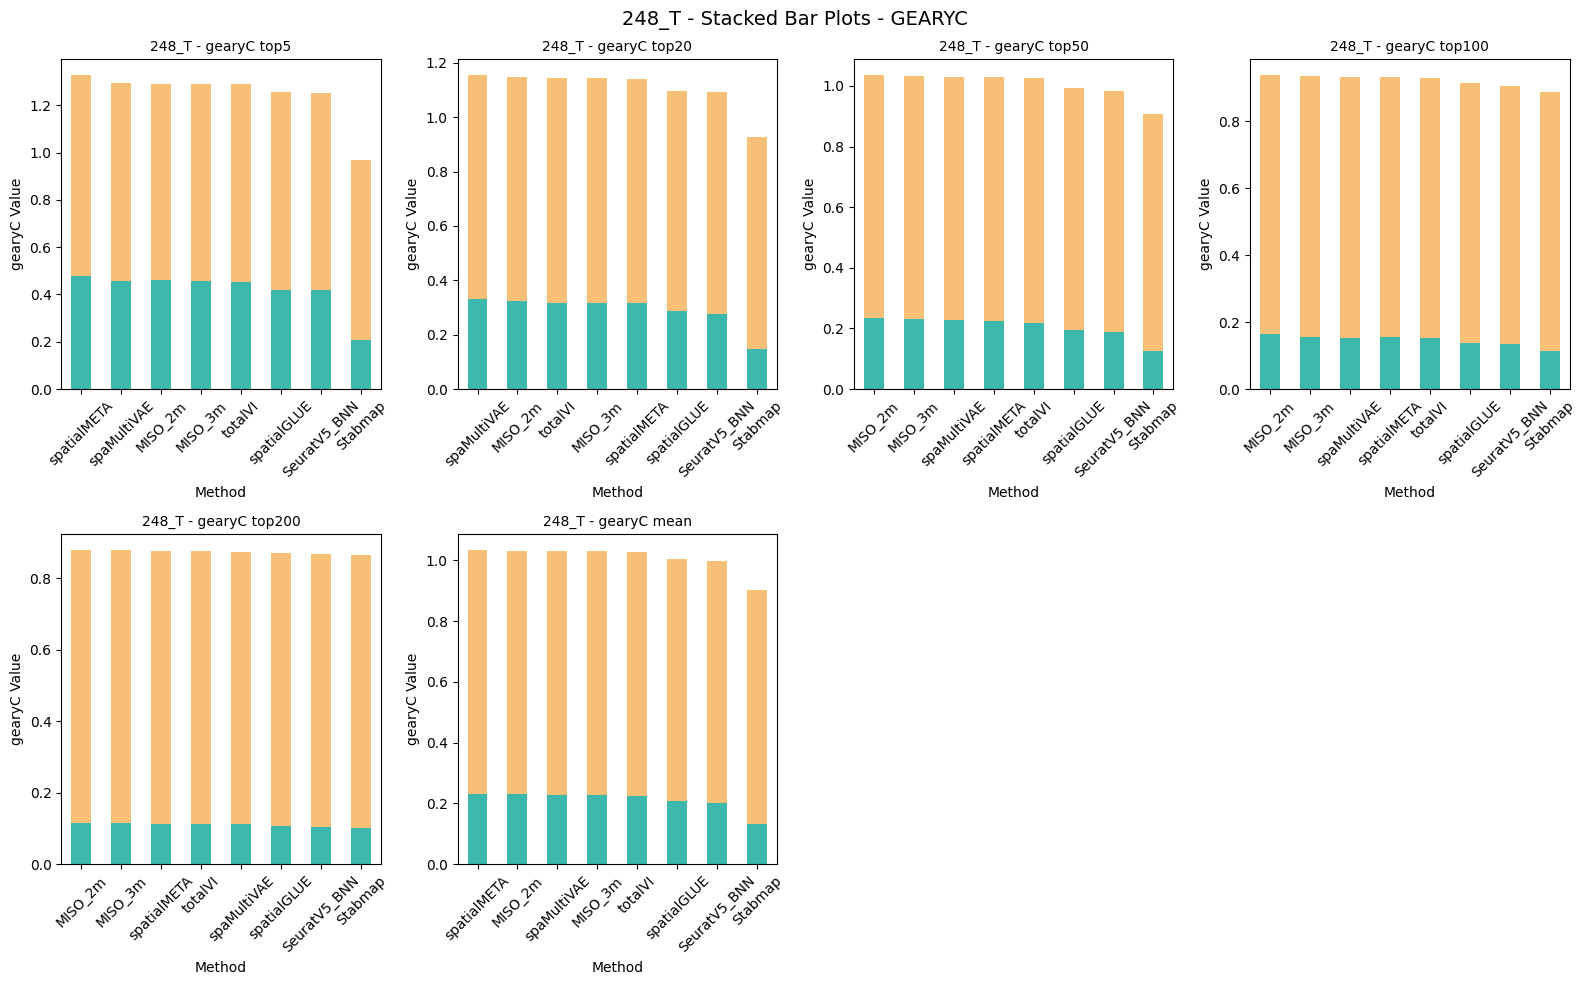

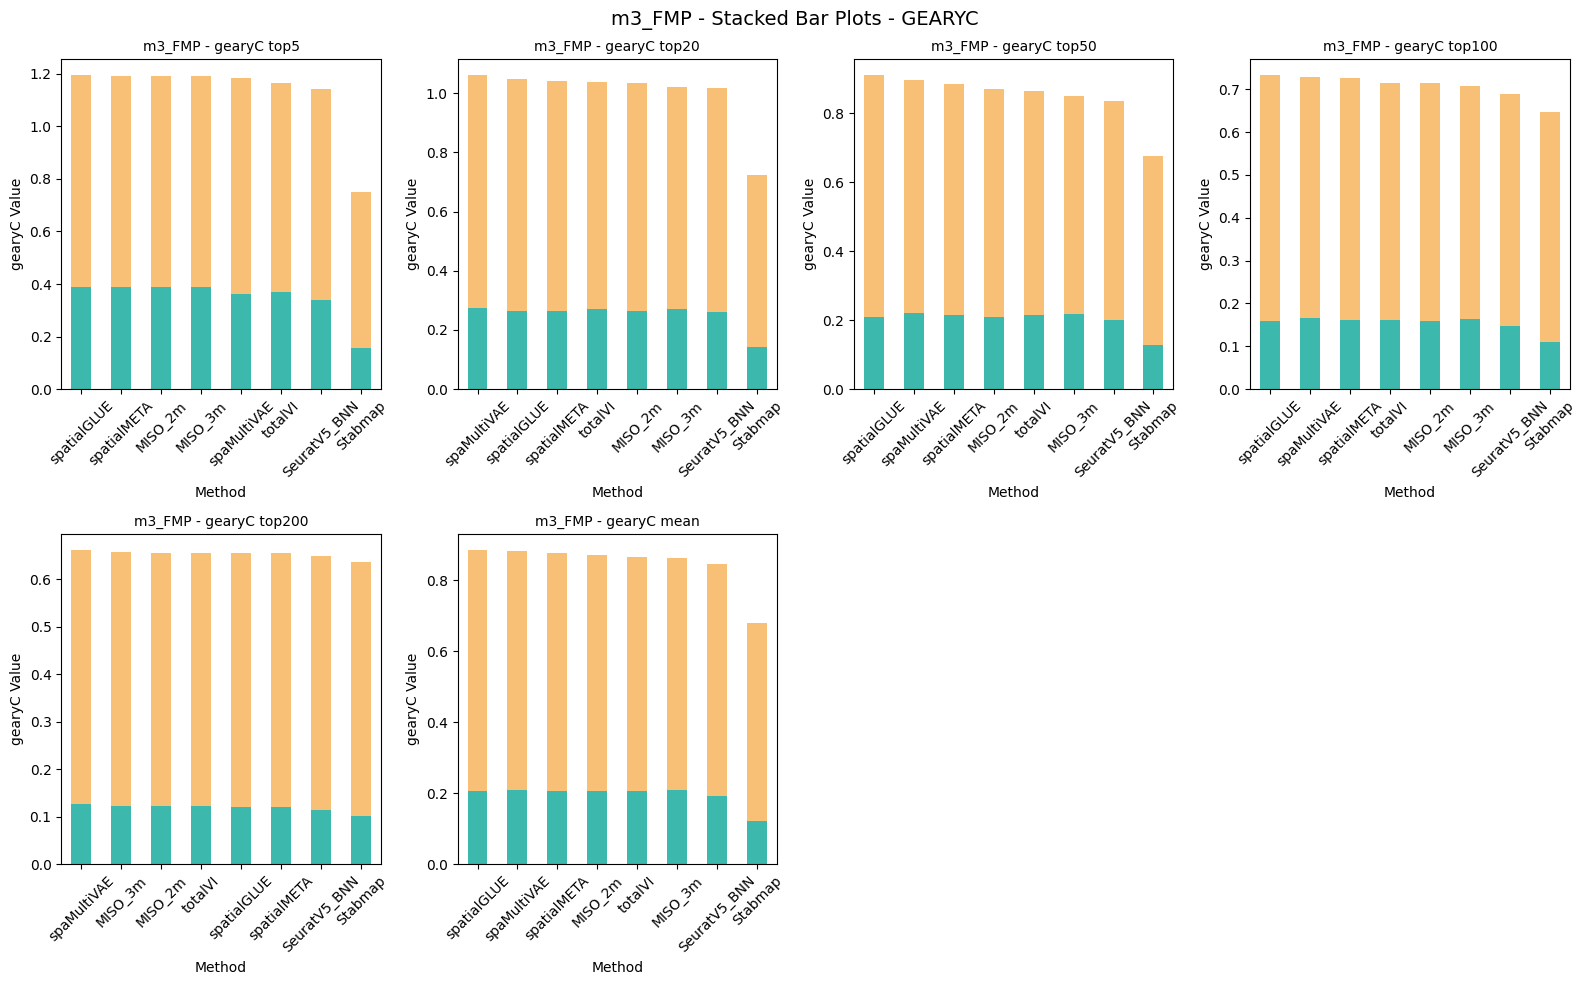

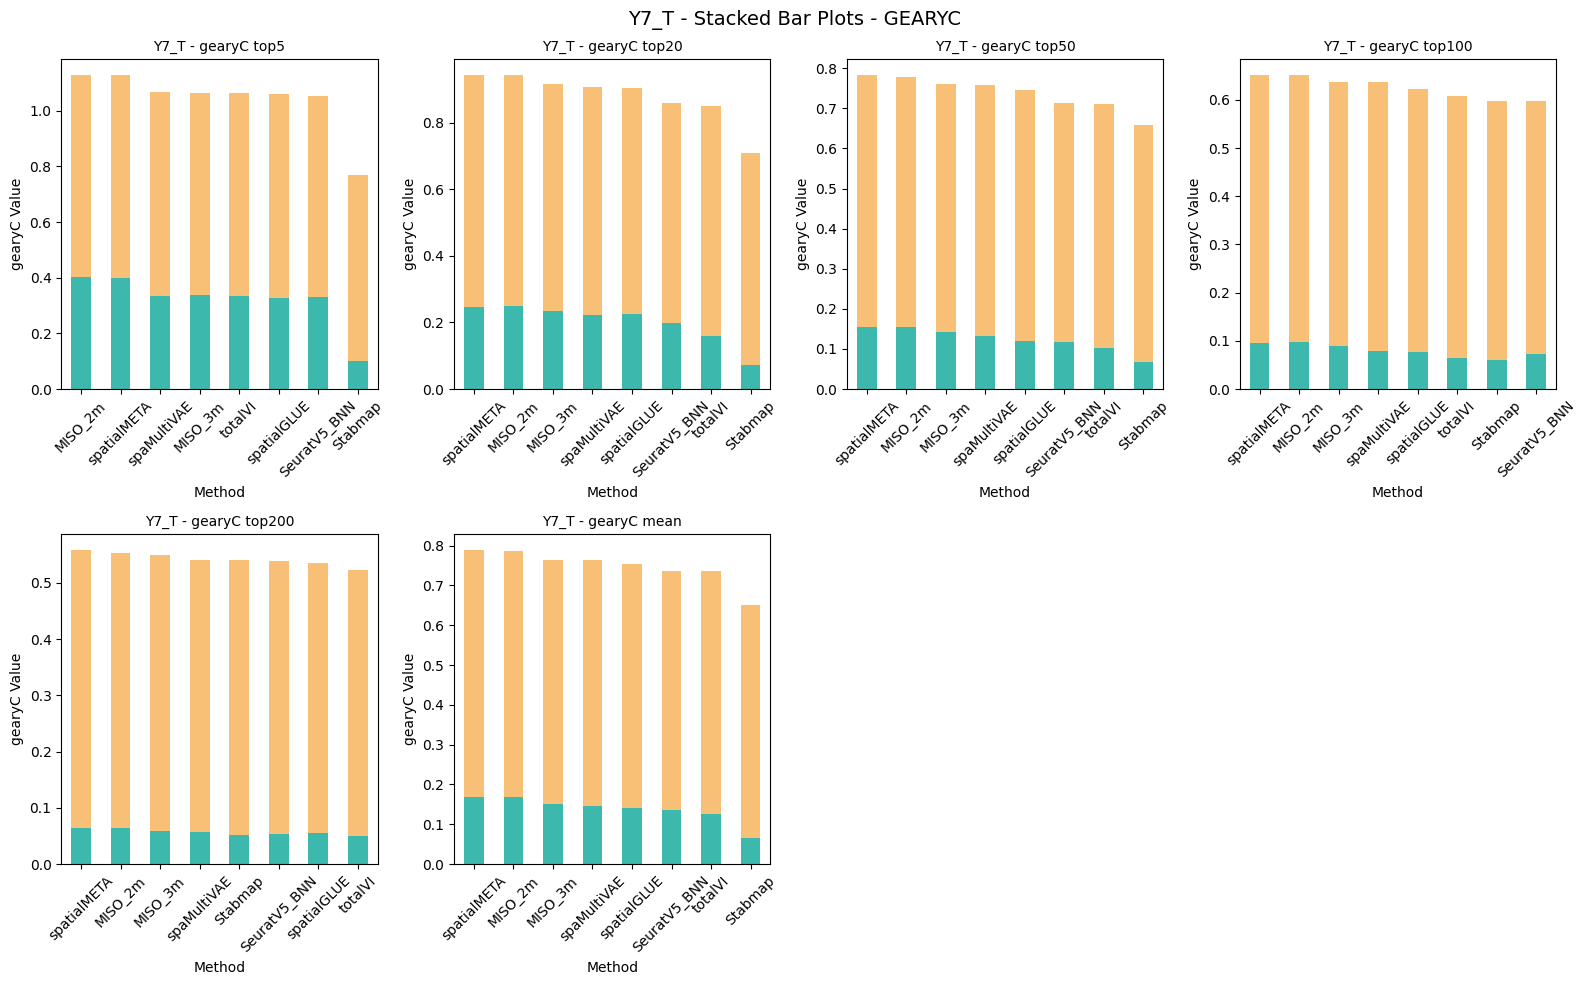

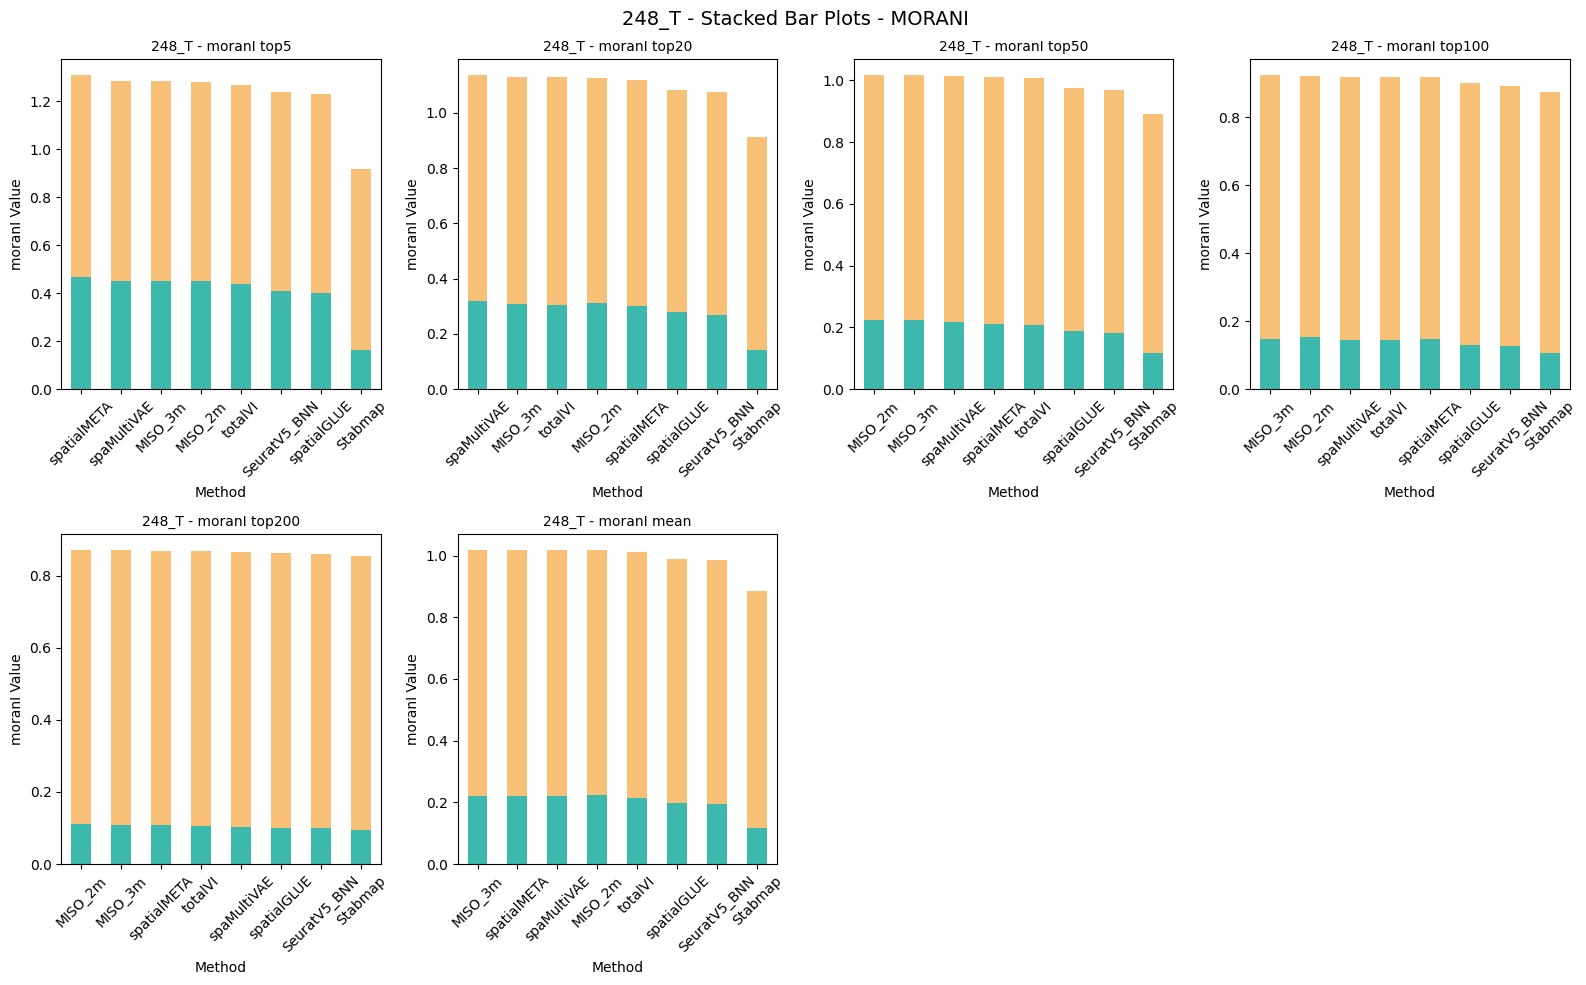

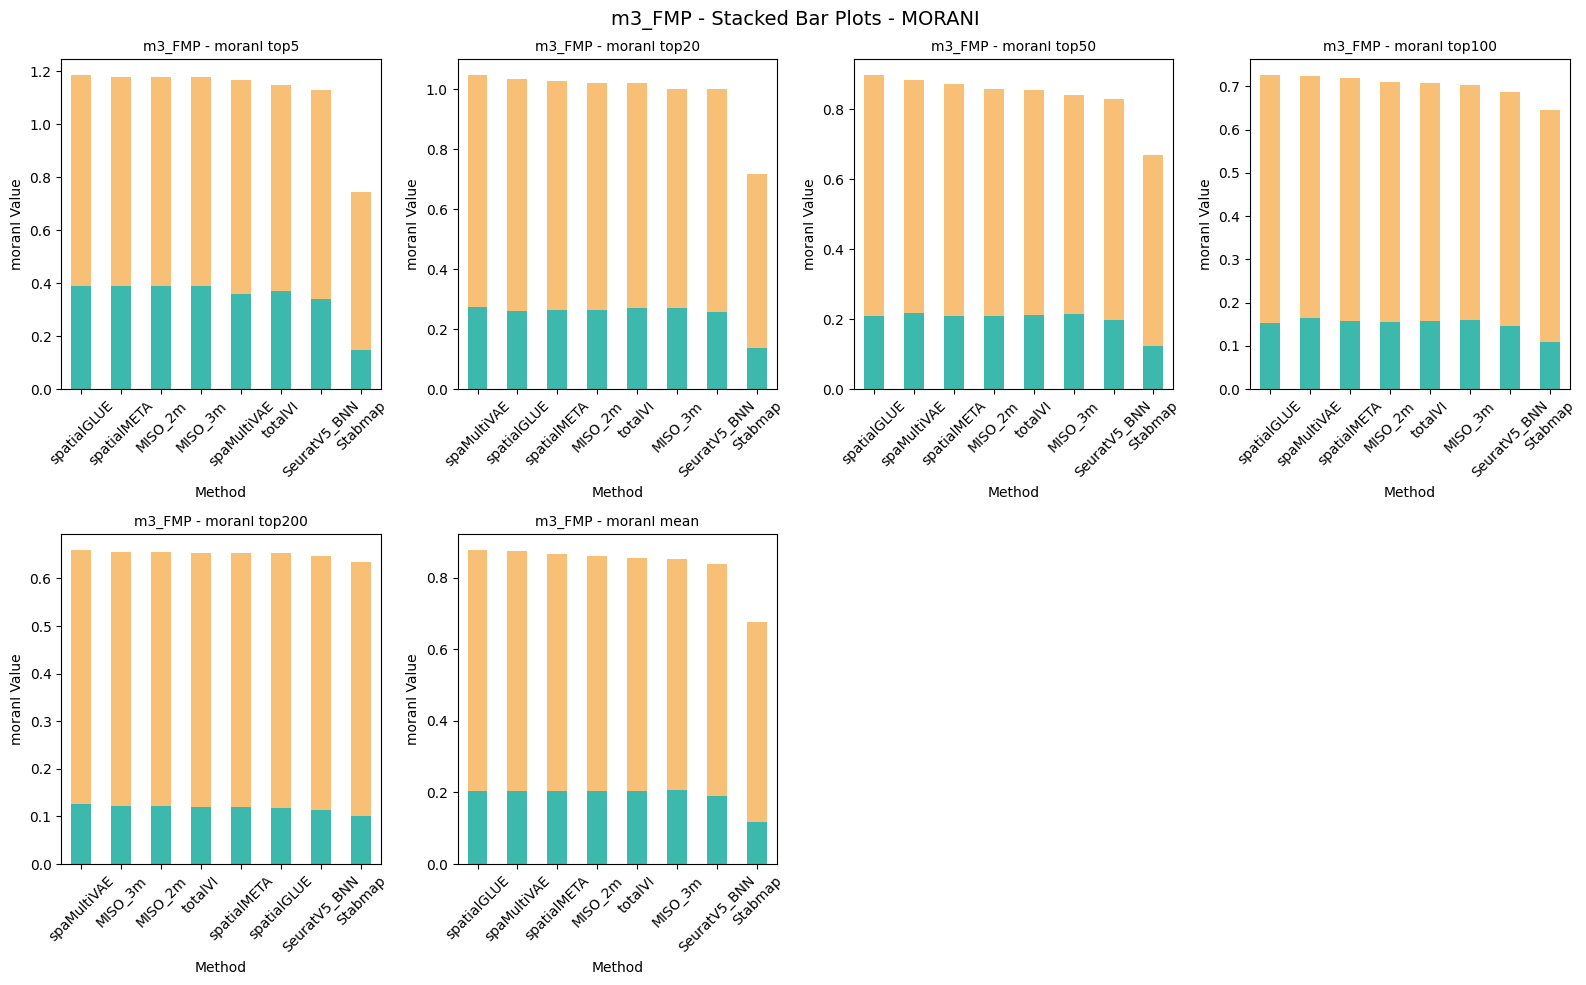

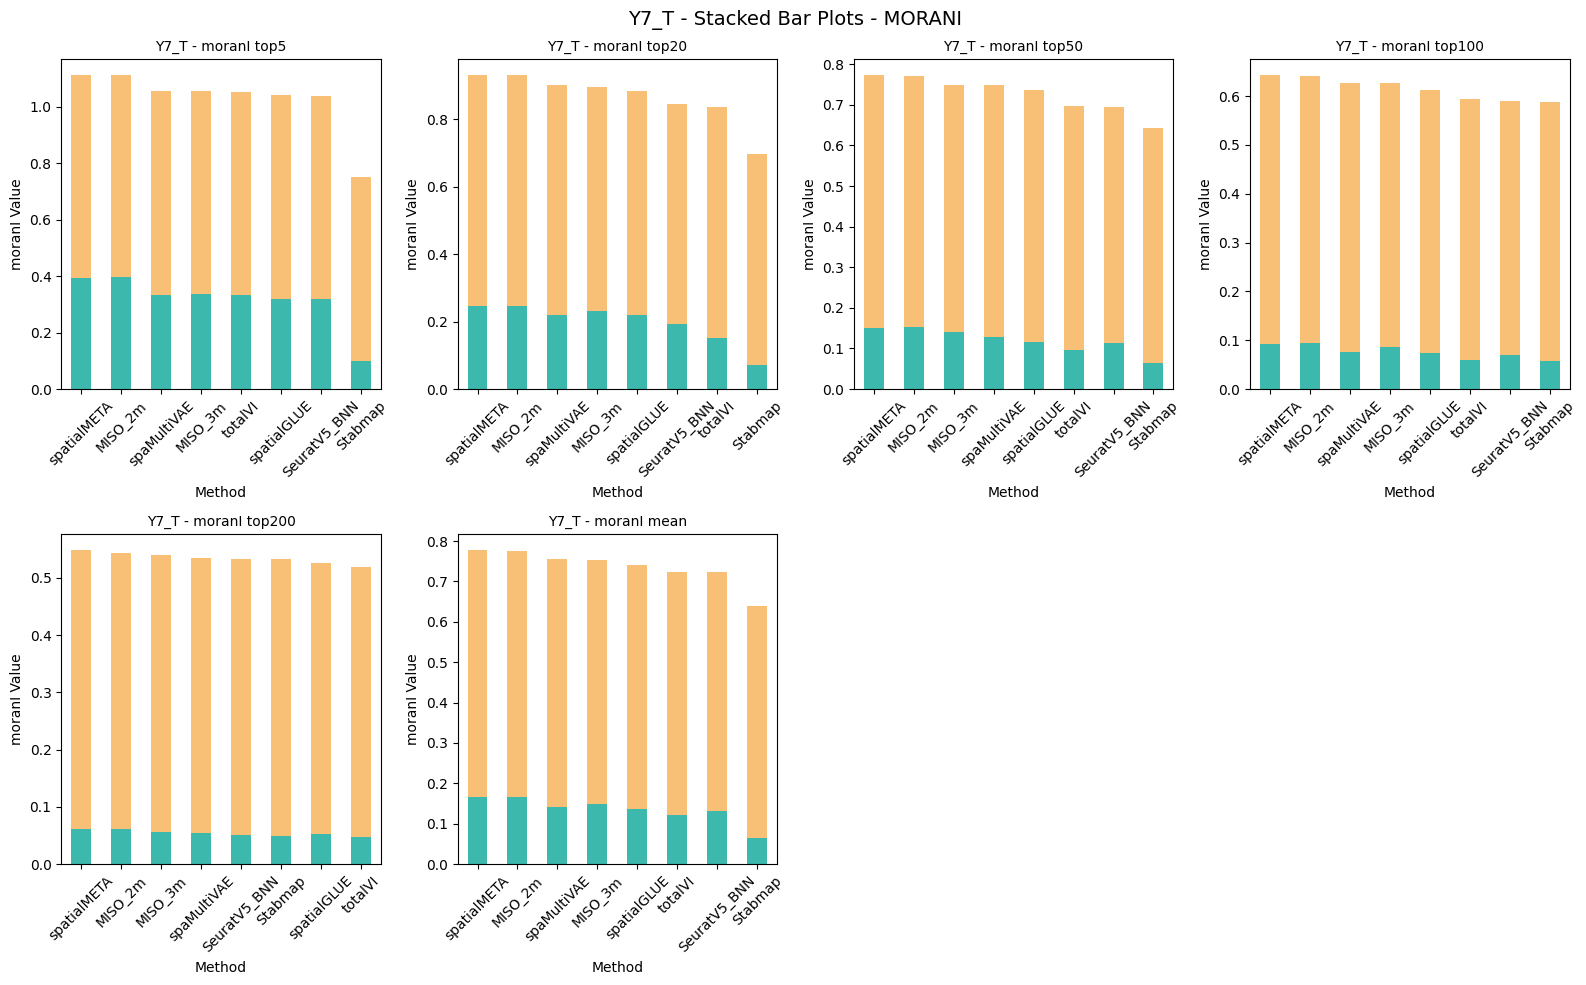

In [100]:
for j in ['gearyC', 'moranI']:
    for sample in samples:
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
        axes = axes.flatten()

        for i, top_val in enumerate(top_values):
            if i >= len(axes):
                break

            ax = axes[i]

            st_col = f'ST_{j}_{top_val}'
            sm_col = f'SM_{j}_{top_val}'

            if st_col in results_df.columns and sm_col in results_df.columns:
                sample_df = results_df[
                    (results_df['method'] != 'PCA') &
                    (results_df['sample'] == sample)  # <-- sample filtering
                ].copy()

                if not sample_df.empty:
                    plot_data = sample_df[['method', st_col, sm_col]].groupby('method').mean()
                    plot_data['total'] = plot_data[st_col] + plot_data[sm_col]
                    plot_data = plot_data.sort_values('total', ascending=False)
                    plot_data.drop(columns='total', inplace=True)
                    plot_data.plot(kind='bar', stacked=True,
                                   color=['#3DB8AC', '#F7C076'],
                                   ax=ax, legend=False)

                    ax.set_title(f'{sample} - {j} {top_val}', fontsize=10)
                    ax.set_xlabel('Method')
                    ax.set_ylabel(f'{j} Value')
                    ax.tick_params(axis='x', rotation=45)
                else:
                    ax.text(0.5, 0.5, f'No data for\n{sample}', 
                            ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, f'Data not available\nfor {j} {top_val}', 
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{j} {top_val} (No Data)', fontsize=10)

        for idx in range(len(top_values), len(axes)):
            fig.delaxes(axes[idx])

        plt.suptitle(f'{sample} - Stacked Bar Plots - {j.upper()}', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{sample}_{j}_stacked_barplot_extended.pdf"), bbox_inches='tight')
        plt.show()
